# Out of Core Processing
In this notebook we will look at formulating inference on data when its large enough that it does not fit in memory. Specifically, we will compare different toolkits for loading and processing the data. The data that we will use comes from a traditional example, the 'Airline' dataset of all air traffic in the US over a period of years.

Let's start by downloading the data to our machines.

You can access descriptions of the data files from here: http://stat-computing.org/dataexpo/2009/the-data.html. You can manually download each of the zipped files OR run the following scripts to download the files into a folder in the same directory as this notebook called "large_data".

In the following blocks of code, we download the data and then decompress the files into .csv files. Each csv contains data for one year of airline flights. Later on we will try two different packages for analyzing this data and building models to predict upon it:
- Dask (using python 3.5 or later), this notebook (12a)
- Graphlab (using python 2.7), another notebook (12b). Note: *A beta version of graphlab for python 3.5 exists, but currently is not recommended. That's fine--because we are using anaconda we can easily setup an environment for running python 2.7.*


In [1]:
# standard imports
import os, sys
import os.path
import urllib.request # this is part of the standard library for python
import bz2 # this is also part of the python standard library

# common third party imports 
import numpy as np
import pandas as pd
from scipy import sparse
from matplotlib import pyplot as plt
%matplotlib inline

# for parallelization
from joblib import Parallel, delayed

In [2]:
# create a Data directory if not done already
path = "large_data"
if not os.path.exists(path):
    os.mkdir( path )

In [3]:
%%time
# download all this stuff in parallel
years_to_download = range(1987,2009) # get the years 1987 through 2008
baseurl = 'http://stat-computing.org/dataexpo/2009/%d.csv.bz2' 

# define function for performing single task
def download_files(url,filepath):
    if not os.path.isfile(filepath): 
        urllib.request.urlretrieve(url, filepath) #execute download
        print('Downloading %s to %s'%(url,filepath))

# put together what the files and URLs are
files = []
urls = []
for i,year in enumerate(years_to_download):
    # prepare strings
    url_of_data_file = baseurl%(year) # get the URL for the data file
    save_as_filename = '%s/%d.csv.bz2'%(path, year) # save as this
    files += [save_as_filename] # save name of the compressed file
    urls += [url_of_data_file]
    
# download files in parallel
backend = 'multiprocessing' #'multiprocessing','threading'
%time Parallel(n_jobs=-1,backend=backend)(delayed(download_files)(url, file) for (url,file) in zip(urls,files))
    
# depending on your download speed this will take a few minutes to perform
print(files)

CPU times: user 162 ms, sys: 61.1 ms, total: 223 ms
Wall time: 2min 5s
['large_data/1987.csv.bz2', 'large_data/1988.csv.bz2', 'large_data/1989.csv.bz2', 'large_data/1990.csv.bz2', 'large_data/1991.csv.bz2', 'large_data/1992.csv.bz2', 'large_data/1993.csv.bz2', 'large_data/1994.csv.bz2', 'large_data/1995.csv.bz2', 'large_data/1996.csv.bz2', 'large_data/1997.csv.bz2', 'large_data/1998.csv.bz2', 'large_data/1999.csv.bz2', 'large_data/2000.csv.bz2', 'large_data/2001.csv.bz2', 'large_data/2002.csv.bz2', 'large_data/2003.csv.bz2', 'large_data/2004.csv.bz2', 'large_data/2005.csv.bz2', 'large_data/2006.csv.bz2', 'large_data/2007.csv.bz2', 'large_data/2008.csv.bz2']
CPU times: user 163 ms, sys: 61.8 ms, total: 225 ms
Wall time: 2min 5s


In [4]:
%%time
# decompress each of the files in parallel
def decompress(filename):
    # get file names
    filepath = filename
    newfilepath = filename[:-4]
    if not os.path.isfile(newfilepath):
        print('Decompressing', filepath,'to', newfilepath)

        # go through the decompressed chunks and write out to a decompressed file
        with open(newfilepath, 'wb') as new_file, bz2.BZ2File(filepath, 'rb') as file:
            for data in iter(lambda : file.read(100 * 1024), b''):
                new_file.write(data)
    
# this will also take several minutes to decompress
%time Parallel(n_jobs=-1,backend=backend)(delayed(decompress)(file) for file in files)
print('Done!')

CPU times: user 60.7 ms, sys: 21.8 ms, total: 82.4 ms
Wall time: 187 ms
Done!
CPU times: user 65.5 ms, sys: 22.6 ms, total: 88.1 ms
Wall time: 193 ms


### If you want to delete the compressed files
Run the following block ONLY if you want to delete the compressed bz2 files from your system.

In [5]:
!rm large_data/*.bz2

___
Now let's take a look at the data that we downloaded.

In [6]:
print('CSV File Format\n==================')

# run a terminal command to peak into file
!head large_data/1987.csv

CSV File Format
Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1987,10,14,3,741,730,912,849,PS,1451,NA,91,79,NA,23,11,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,15,4,729,730,903,849,PS,1451,NA,94,79,NA,14,-1,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,17,6,741,730,918,849,PS,1451,NA,97,79,NA,29,11,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,18,7,729,730,847,849,PS,1451,NA,78,79,NA,-2,-1,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,19,1,749,730,922,849,PS,1451,NA,93,79,NA,33,19,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,21,3,728,730,848,849,PS,1451,NA,80,79,NA,-1,-2,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,22,4,728,730,852,849,PS,1451,NA,84,79,NA,3,-2,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,23,5,731,730

In [7]:
%%time
# there is a problem in this dataset, however
# years 2001 and 2002 will fail to read in the column 'TailNum'
# because of odd-encoded bytes that pandas/dask can't resolve

# a solution comes from just replacing those improperly encoded bytes with '?'
# http://stackoverflow.com/questions/38728366/pandas-cannot-load-data-csv-encoding-mystery
for year in [2001,2002]:
    print(year)
    in_filename = 'large_data/%d.csv'%(year)
    out_filename = 'large_data/%d_repaired.csv'%(year)

    from functools import partial
    chunksize = 100*1024*1024 # read 100MB at a time

    # Decode with UTF-8 and replace errors with "?"
    with open(in_filename, 'rb') as in_file:
        with open(out_filename, 'w') as out_file:
            for byte_fragment in iter(partial(in_file.read, chunksize), b''):
                out_file.write(byte_fragment.decode(encoding='utf_8', errors='replace'))
            
    os.remove(in_filename)
    os.rename(out_filename, in_filename)
                


2001
2002
CPU times: user 1.62 s, sys: 2.88 s, total: 4.5 s
Wall time: 6.63 s


___
# Analyzing the Data with Dask
Let's perform some analysis of the data using the Dask framework, which is an open source implementation that breaks apart the data using multiple pandas arrays saved as structs on disk (conceptually this is an okay way to think about Dask). 

Many examples from this code come from "Jim Crist at Continuum Analytics". Especially this example:
- https://jcrist.github.io/dask-sklearn-part-3.html 

But I would check out all of the posts, they are great learning tools for the dask environment (in addition to dask-learn):
- https://jcrist.github.io/dask-sklearn-part-1.html
- https://jcrist.github.io/dask-sklearn-part-2.html
- https://jcrist.github.io/dask-sklearn-part-3.html 

In [8]:
# standard dask imports
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from distributed import Client

# experimental dask-learn imports (these will likely change)
import dklearn.matrix as dm
from dklearn.cross_validation import train_test_split
from dklearn.cross_validation import RandomSplit
from dklearn.grid_search import GridSearchCV
from dklearn import Averaged

# scikit-learn imports
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [1]:
import dask.dataframe as dd

# you can run distributed here, if you have more than one machine
#    but for lecture, we will just use the laptop

# These can be used for a distributed setup, but since we are running from a laptop...
#   we won't run them
# from distributed import Client
# client = Client() # start a LocalCluster for testing purposes
# print(client) # shows where local asynchronous server (or distributed cluster) is running 

In [9]:
# Subset of the columns to use
cols = ['Year', 'Month', 'DayOfWeek', 'DepDelay',
        'CRSDepTime', 'UniqueCarrier', 'Origin', 'Dest', 'TailNum']

# Create the dataframe
df = dd.read_csv('large_data/*.csv',
                 usecols=cols,           # names
                 blocksize=int(128e6),   # size of chunks
                 dtype = {'TailNum':object}) # specify type of hard to interpret columns
df

dd.DataFrame<from-de..., npartitions=104>

In [10]:
df = (df.drop(['DepDelay', 'CRSDepTime'], axis=1).assign(
        hour=df.CRSDepTime.clip(upper=2399)//100, 
        # make hour go up to midnight, floor division to make hourly
        delayed=(df.DepDelay.fillna(16) > 15).astype('i8')
        # fill na with 16 and save true/false as 8 bit integer
    ))

In [11]:
# this call to compute tells dask to run 
#  and then return the results to the scheduler
#  since we are running on a laptop, the results are already here
#  but in a cluster, this would trigger data transfer back to the local machine

# we could instead call client.persist(df) to trigger computation
#   but the results would stay in memory on the workers, instead of sending back
#   to the scheduler
%time df.compute()

CPU times: user 5min 3s, sys: 1min 26s, total: 6min 30s
Wall time: 3min 33s


,Year,Month,DayOfWeek,UniqueCarrier,TailNum,Origin,Dest,delayed,hour
0,1987,10,3,PS,NaN,SAN,SFO,0,7
1,1987,10,4,PS,NaN,SAN,SFO,0,7
2,1987,10,6,PS,NaN,SAN,SFO,0,7
3,1987,10,7,PS,NaN,SAN,SFO,0,7
4,1987,10,1,PS,NaN,SAN,SFO,1,7
5,1987,10,3,PS,NaN,SAN,SFO,0,7
6,1987,10,4,PS,NaN,SAN,SFO,0,7
7,1987,10,5,PS,NaN,SAN,SFO,0,7
8,1987,10,6,PS,NaN,SAN,SFO,0,7
9,1987,10,7,PS,NaN,SAN,SFO,0,7


In [12]:
print(df.info())

<class 'dask.dataframe.core.DataFrame'>
Data columns (total 9 columns):
Year               int64
Month              int64
DayOfWeek          int64
UniqueCarrier      object
TailNum            object
Origin             object
Dest               object
delayed            int64
hour               int64
dtypes: int64(5), object(4)None


In [13]:
%%time
# now let's also use some cool feedback while processing, like the progress bar
from dask.diagnostics import ProgressBar

# Define some aggregations to plot
aggregations = (df.groupby('Year').delayed.mean(), 
                df.groupby('Month').delayed.mean(),
                df.groupby('hour').delayed.mean(),
                df.groupby('UniqueCarrier').delayed.mean().nlargest(15), #get largest delays from 15 carriers
                df.groupby('TailNum').delayed.mean().nlargest(30), # a specific plane that is delayed
               )

with ProgressBar():
    # Compute them all in a single pass over the data
    (delayed_by_year,  
     delayed_by_month, 
     delayed_by_hour,  
     delayed_by_carrier,
     delayed_by_plane) = dd.compute(*aggregations)


[########################################] | 100% Completed |  3min 13.5s
CPU times: user 5min 48s, sys: 1min 15s, total: 7min 3s
Wall time: 3min 13s


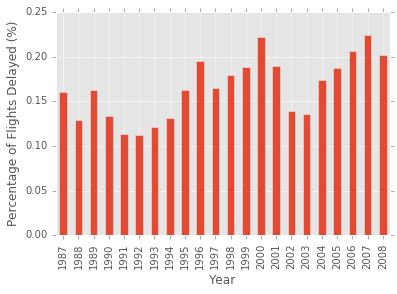

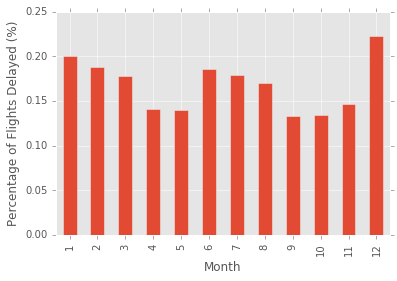

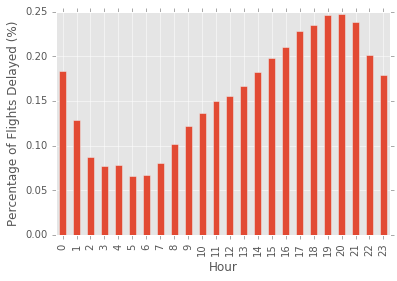

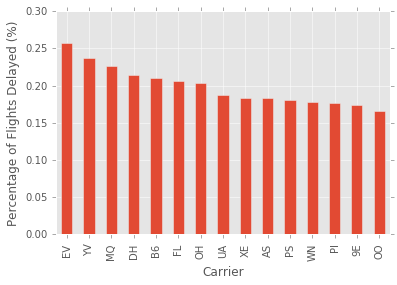

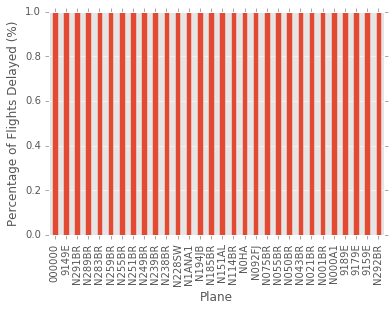

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

vals = (delayed_by_year,delayed_by_month,delayed_by_hour,delayed_by_carrier,delayed_by_plane)
names = ('Year','Month','Hour','Carrier','Plane')
for val,name in zip(vals,names):
    plt.figure()
    val.plot(kind='bar')
    plt.xlabel(name)
    plt.ylabel('Percentage of Flights Delayed (%)')
    plt.grid(True)
    
plt.show()

Wow! REALLY?, these planes never flew without being delayed? How many flights did these planes actually take?

In [21]:
idxs = df.TailNum=='N291BR'
df_plane = df[idxs]

In [23]:
%%time
with ProgressBar():
    num_flights = dd.compute(df_plane[idxs].count())
    
print(num_flights)

[#                                       ] | 2% Completed |  7.8s

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/dask/async.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = _execute_task(task, data)


[########################################] | 100% Completed |  2min 43.0s
(DayOfWeek        1
Dest             1
Month            1
Origin           1
TailNum          1
UniqueCarrier    1
Year             1
delayed          1
hour             1
dtype: int64,)
CPU times: user 5min 8s, sys: 1min 1s, total: 6min 9s
Wall time: 2min 43s


Oh! so these planes probably only flew one time and that one flight was delayed...

How can we customize a groupby pass through the dataset such that we only look at flights flown many times? 

In [24]:
%%time
agg = (df.groupby('TailNum').delayed.mean(),
       df.groupby('TailNum').delayed.count())
#get these aggregations in a single pass
with ProgressBar():
    (delay_mean,delay_count) = dd.compute(*agg)

[########################################] | 100% Completed |  2min 47.6s
CPU times: user 5min 15s, sys: 1min 2s, total: 6min 18s
Wall time: 2min 47s


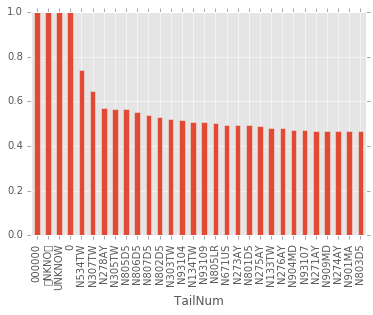

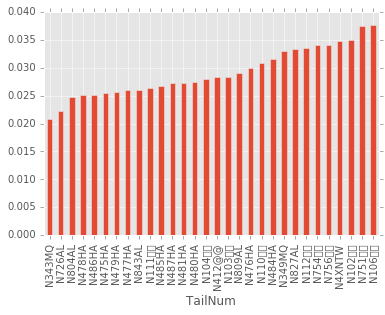

In [25]:
n_flights = 100
delay_mean_large = delay_mean[delay_count.values>n_flights]
delay_mean_large.nlargest(30).plot(kind='bar')
plt.figure()
delay_mean_large.nsmallest(30).plot(kind='bar')

___

# Using Machine Learning with Dask
So here is where the beta parts of Dask get uncovered. Even still, there is some basic functionality for using Dask that are quite powerful, and they mirror the syntax of scikit-learn that we already understand. 

Again, these examples have been manipualted from the blog of "Jim Crist at Continuum Analytics":
- https://jcrist.github.io/dask-sklearn-part-1.html
- https://jcrist.github.io/dask-sklearn-part-2.html
- https://jcrist.github.io/dask-sklearn-part-3.html 

In [26]:
import pandas as pd
import numpy as np
from dask import delayed
from scipy import sparse

def one_hot_encode_series(s, categories, dtype='f8'):
    """Transform a pandas.Series into a sparse matrix by one-hot-encoding
    for the given `categories`"""
    cat = pd.Categorical(s, np.asarray(categories))
    codes = cat.codes
    n_features = len(cat.categories)
    n_samples = codes.size
    mask = codes != -1
    if np.any(~mask):
        raise ValueError("unknown categorical features present %s "
                        "during transform." % np.unique(s[~mask]))
    row_indices = np.arange(n_samples, dtype=np.int32)
    col_indices = codes
    data = np.ones(row_indices.size)
    
    # this is the line where the magic actually happens for 
    # one hot encoding
    return sparse.coo_matrix((data, (row_indices, col_indices)),
                            shape=(n_samples, n_features),
                            dtype=dtype).tocsr()


@delayed(pure=True)
def one_hot_encode(df, categories, dtype='f8'):
    """One-hot-encode a pandas.DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
    categories : dict
        A mapping of column name to an sequence of categories for the column.
    dtype : str, optional
        The dtype of the output array. Default is 'float64'.
    """
    arrs = [one_hot_encode_series(df[col], cats, dtype=dtype)
            for col, cats in sorted(categories.items())]
    return sparse.hstack(arrs).tocsr()

## Self Test: Is there an error in the code below?
- A. No, it runs
- B. No, each value can correctly be interpretted as categorical
- C. Yes. Ordinal data is present.
- D. Yes. Dynamic range of integers is squashed.

In [27]:
# Extract categories for each feature
categories = dict(Year=np.arange(1987, 2009),
                  Month=np.arange(1, 13),
                  DayOfWeek=np.arange(1, 8),
                  hour=np.arange(24),
                  UniqueCarrier=df.UniqueCarrier.unique(),
                  Origin=df.Origin.unique(),
                  Dest=df.Dest.unique(),
                  TailNum=df.TailNum.unique())

# Compute all the categories in one pass
with ProgressBar(): 
    categories = delayed(categories).compute()

[########################################] | 100% Completed |  2min 40.6s


In [28]:
# what about usingbetter visuals as part of Dask?
# Extract categories for each feature

categories = dict(Year=np.arange(1987, 2009),
                  Month=np.arange(1, 13),
                  DayOfWeek=np.arange(1, 8),
                  hour=np.arange(24),
                  UniqueCarrier=df.UniqueCarrier.unique(),
                  Origin=df.Origin.unique(),
                  Dest=df.Dest.unique(),
                  TailNum=df.TailNum.unique())

from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof:
    categories = delayed(categories).compute()

In [29]:
from dask.diagnostics import visualize
visualize([prof, rprof])

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/bokeh/core/validation/check.py - WARNING - W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='bbc4d306-0e86-461a-b963-329f010673c3', ...)
/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/bokeh/core/validation/check.py - WARNING - W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='73962658-c87c-498f-bee0-9a0f10536871', ...)
/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/bokeh/core/validation/check.py - WARNING - W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='18b8b8b5-761e-4ee8-b2be-84e709530fcc', ...)
/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/bokeh/core/validation/check.py - WARNING - W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='bbc4d306-0e86-461a-b963-329f010673c3', ...)
/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/bokeh/core/validation/check.py - WARNING - W-1001 (NO_DATA_RENDE

Column(id='131cae26-702e-4d19-8fa1-f7fb78cef8a8', ...)

In [28]:
# you will need an experimental setup as described here:
# pip install git+https://github.com/dask/dask-learn

# Dask Learn is an experimental project, but you 
#   can still use it as a ML expert!
import dklearn.matrix as dm

# Convert the series `delayed` into a `Matrix`
y = dm.from_series(df.delayed)

# `to_delayed` returns a list of `dask.Delayed` objects, each representing
# one partition in the total `dask.dataframe`
# Sorry about the delayed syntax for this example...
chunks = df.to_delayed() # delayed paritions

# Apply `one_hot_encode` to each chunk, and then convert all the
# chunks into a `Matrix`
X = dm.from_delayed([one_hot_encode(x, categories) for x in chunks],
                    dtype='f8')
X, y

(dklearn.matrix<matrix-..., npartitions=104, dtype=float64>,
 dklearn.matrix<matrix-..., npartitions=104, dtype=int64>)

In [29]:
from dklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
from dklearn import Averaged
from sklearn.linear_model import SGDClassifier

# if you had this in separate clusters, build different 
#   ensembles inside each
est = Averaged(SGDClassifier())

In [31]:
from dklearn.cross_validation import RandomSplit
from dklearn.grid_search import GridSearchCV


grid = {'alpha': [1e-5, 1e-4], # regularization
        'loss': ['log', 'hinge']} # logistic regression versus linear SVM

search = GridSearchCV(est, grid,
                      cv=RandomSplit(n_iter=3, test_size=0.2),
                      scoring='f1')

In [59]:
import warnings
warnings.filterwarnings("ignore")

with Progressbar():
    search.fit(X_train, y_train)

CPU times: user 1h 33min 52s, sys: 14min 19s, total: 1h 48min 11s
Wall time: 37min 33s


GridSearchCV(cv=<dklearn.cross_validation.RandomSplit object at 0x11497e828>,
       estimator=Averaged(SGDClassifier(alpha=0.0001, average=False, class_weight=None,
          epsilon=0.1,eta0=0.0, fit_intercept=True,
          l1_ratio=0.15,learning_rate='optimal', loss='hinge',
          n_iter=5, n_jobs=1,penalty='l2', power_t=0.5,
          random_state=None, shuffle=True,verbose=0,
          warm_start=False)),
       fit_params={}, get=None, iid=True,
       param_grid={'loss': ['log', 'hinge'], 'alpha': [0.0001, 0.001]},
       refit=True, scoring='f1')

In [60]:
print(search.best_estimator_)

from sklearn.metrics import accuracy_score, f1_score

# Call `predict` in parallel on the testing data
y_pred = search.predict(X_test)# lazy implementation

# Compute the actual and predicted targets
%time actual, predicted = dask.compute(y_test, y_pred) # actualy perform computation

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


0.67796268512988833

In [61]:
# Score 
print(accuracy_score(actual, predicted))
print(f1_score(actual, predicted))

0.67796268513
0.333617496122
